# <font color="orange">**Eργασία 3: Βαθιά Μάθηση**</font>

**Ομάδα 40**
*   Μαριαλένα Βαγγελάτου (ΑΜ: 03118141)
*   Νικόλαος Μπλέτσας (ΑΜ: 03118899)
*   Γεώργιος Τζουμανέκας (ΑΜ: 03118095)

### Setup

Για αρχή θα πρέπει να κατεβάσουμε τα αναγκαία πακέτα και να κάνουμε import τις βιβλιοθήκες που ορίζονται και στο tutorial.

In [ ]:
! apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
! pip uninstall -y tensorflow estimator keras
! pip install -U tensorflow_text tensorflow tensorflow_datasets
! pip install einops

In [ ]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
print("Έκδοση Tensorflow: " + tf.__version__)

Έκδοση Tensorflow: 2.11.0


Έπειτα ακολουθώντας τον τρόπο εκπαίδευσης του μοντέλου που περιγράφεται στο tutotial θα εφαρμόσουμε τις βελτιστοποιήσεις όπου μπορούμε.

### Preprocessing

#### Σύνολο Δεδομένων

Θα χρησιμοποιήσουμε το dataset που μας υποδείχθηκε από την εκφώνηση.

In [ ]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 399s 0us/step


In [ ]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

Οργανώνουμε τα filenames και τα captions σε λίστες και ετοιμάζουμε τα train και test sets για το TensorFlow.

In [ ]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

# we'll do it later   
# train_raw = tf.data.experimental.from_list(train_captions)
# test_raw = tf.data.experimental.from_list(test_captions)

### Προεπεξεργασία κειμένου

Θα δοκιμάσουμε αρχικά να φτιάξουμε ένα ιστόγραμμα στο οποίο θα φαίνονται τα μήκη όλων των captions ώστε να κρατήσουμε τα πιο συχνά μήκη.

In [ ]:
print(len(train_captions) + len(test_captions))

25524


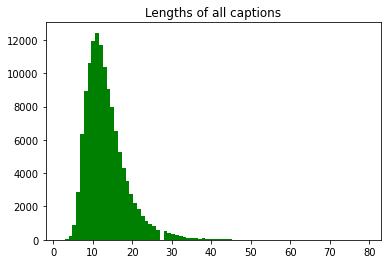

In [ ]:
lengths = []

for i in range (len(train_captions)):
  for j in range (5):
    lengths.append(len(train_captions[i][1][j].split()))

for i in range (len(test_captions)):
  for j in range (5):
    lengths.append(len(test_captions[i][1][j].split()))

plt.title("Lengths of all captions")
plt.hist(lengths, bins=80, color="green")
plt.show()

Παρατηρούμε πως τα περισσότερα captions έχουν μήκος κοντά στο 10-15, θα μπορούσαμε να σβήσουμε captions με μήκος μικρότερο από 3 και μεγαλύτερο από 45, χωρις να έχουμε πρόβλημα στην απόδοση του μοντέλου, ωστόσο είναι πολύ μικρά σε αριθμό και θα δημιουργήσουμε πρόβλημα στο batch

Δείχνουμε ενδεικτικά και το path της πρώτης εικόνας και τα 5 captions.

In [ ]:
# later is now
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


#### Image feature extractor

Για την βελτιστοποιήση του encoder καταλήξαμε στο δίκτυο InceptionResNetV2. Κάναμε resize τις εικόνες με τελική διάσταση 299x299, ώστε να συμφωνεί με το μέγεθος της εισόδου του InceptionResNetV2.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
    return img

Αρχικοποίηση του InceptionResNetV2 και φόρτωση των προεκπαιδευμένων βαρών Imagenet.

In [ ]:
image_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Το μοντέλο επιστρέφει έναν χάρτη χαρακτηριστικών για κάθε εικόνα στην παρτίδα εισόδου και παρακάτω φαίνεται το μέγεθος του:

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(image_model(test_img_batch).shape)

(1, 299, 299, 3)
(1, 8, 8, 1536)


#### Setup the text tokenizer/vectorizer

Μετατρέπουμε τις λεζάντες κειμένου σε ακολουθίες ακέραιων αριθμών με το επίπεδο TextVectorization, με τα ακόλουθα βήματα που τονίζονται στην εκφώνηση:

* Χωρίζουμε τους υπότιτλους σε λέξεις και υπολογίζουμε ένα λεξιλόγιο των κορυφαίων λέξεων. Επιλέξαμε να κρατήσουμε το 10000 που εμφάνιζε την καλύτερη απόδοση από κάποια ενδεικτικά που χρησιμοποιήσαμε

* Προσαρμόζουμε όλους τους υπότιτλους αντιστοιχίζοντας κάθε λέξη στο ευρετήριό της στο λεξιλόγιο. Όλες οι ακολουθίες εξόδου θα γεμιστούν σε μήκος 50

* Δημιουργούμε αντιστοιχίσεις λέξης σε ευρετήριο και ευρετηρίου σε λέξη

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Αυτές είναι οι 10 κορυφαίες λέξεις του λεξιλογίου:

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

Αντιστοίχηση λέξης σε ευρετήριο και ευρετήριο σε λέξη και παράδειγμα:

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

#### Prepare the dataset

Τα σύνολα δεδομένων train_raw και test_raw περιέχουν ζεύγη 1-to-many (εικόνα, λεζάντες).

Αυτή η λειτουργία θα αναπαράγει την εικόνα για να δημιουργήσει ζεύγη 1-to-1 εικόνων-λεζάντων.

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


Για να είμαστε συμβατοί με την εκπαίδευση keras, το σύνολο δεδομένων πρέπει να περιέχει ζεύγη (inputs, labels). Αυτή η συνάρτηση θα μετατρέψει ένα ζεύγος (images, texts) σε ένα ζεύγος ((images, input_tokens), label_tokens):

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

Αυτή η συνάρτηση προσθέτει λειτουργίες σε ένα dataset:

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

Το σύνολο δεδομένων επιστρέφει πλέον ζεύγη (inputs, labels) κατάλληλα για εκπαίδευση με keras. Οι είσοδοι είναι ζεύγη (images, input_tokens). Οι εικόνες έχουν υποστεί επεξεργασία με το μοντέλο εξαγωγής των χαρακτηριστικών. Για κάθε θέση στα input_tokens το μοντέλο εξετάζει το κείμενο μέχρι τώρα και προσπαθεί να προβλέψει την επόμενη που είναι παραταγμένη στην ίδια θέση στα labels.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 299, 299, 3)
(32, 36)
(32, 36)


Τα input tokens και τα labels είναι τα ίδια, μετατοπισμένα κάτα 1 βήμα:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  21   9   5   2 369 932   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  2  21   9   5   2 369 932   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


### Model

Θα κατασκευάσουμε το μοντέλο που περιγράφεται στο tutorial με τις ίδιες συναρτήσεις.

Το μοντέλο θα υλοποιηθεί σε τρία κύρια μέρη:

1. Input - SeqEmbedding

2. Decoder - DecoderLayer που αποτελείται από:
  * CausalSelfAttention 
  * CrossAttention
  * FeedForward
  
3. Output

#### Φόρτωση προεκπαιδευόμενων μοντέλων

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-22 15:55:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-22 15:55:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-22 15:55:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Δοκιμάστηκαν τα διαφορετικά μεγέθη διανυσμάτων που είναι και στην εκφώνηση (50,100,200,300) και διαπιστώθηκε πως η χρήση διανυσμάτων μεγέθους 300 λέξεων έδινε τα βέλτιστα αποτελέσματα. Ωστόσο τελικά χρησιμοποιήθηκαν τα αυτοεκπαιδευόμενα embeddings του tutorial, καθώς έδιναν καλύτερους χρόνους εκπαίδευσης.

In [ ]:
path_to_glove_file_300 = os.path.join("glove.6B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file_300) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
voc = tokenizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
     

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9671 words (329 misses)


In [ ]:
import keras 
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Input

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

#### Decoder

Σε αυτό το σημείο θα δοκιμάσουμε διάφορες τιμές για τις παραμέτρους του Decoder.

* **units**: Το units είναι η διάσταση του χώρου εξόδου. Κλασσικές τιμές είναι 32-512. Για μικρά σύνολα δεδομένων ή απλά προβλήματα, ένας μικρότερος αριθμός μονάδων, όπως 32 ή 64, μπορεί να είναι επαρκής. Για μεγαλύτερα σύνολα δεδομένων και πιο σύνθετα προβλήματα, ένας μεγαλύτερος αριθμός μονάδων, όπως 128 ή 256, μπορεί να είναι καταλληλότερος. Πολύ μικροί αριθμοί units θα οδηγούσαν σε χαμηλό accuracy αλλά πολύ μεγάλοι θα μας οδηγούσαν σε overfitting. Ο αριθμός 256 units μετά από λίγο πειραματισμό φάνηκε καλός.

* **dropout_rate**: Το νευρωνικό δίκτυο χρειάζεται να έχει έναν επαρκή αριθμό επιπέδων νευρώνων. Περισσότερα επίπεδα ωστόσο καθιστούν το νευρωνικό δίκτυο ευαίσθητο σε overfitting το οποίο οδηγεί σε αποτυχία. Γι'αυτό τον λόγο χρησιμοποιούνται διάφορες τεχνικές ομαλοποίησης μία εκ των οποίων είναι η προσθήκη επιπέδων Dropout. Επιλέγεται τυχαία ένας αριθμός εξόδων νευρώνων οι οποίες αγνοούνται με βάση κάποια ορισμένη από τον χρήστη πιθανότητα, που καθορίζονται από τον αριθμό droput rate. Με πειραματισμούς η πιθανότητα 0.5 (που αποτελεί και την default) είναι σχετικά καλή επιλογή.

* **num_layers**: Κατά κανόνα, λιγότερα επίπεδα σημαίνουν πιο "ρηχό" δίκτυο που είναι αποτελεσματικό για απλά προβλήματα με μικρά σύνολα δεδομένων, ενώ πιο σύνθετα προβλήματα με μεγαλύτερα σύνολα δεδομένων μπορεί να επωφεληθούν από περισσότερα επίπεδα. Στην πράξη, οι τιμές των num_layers είναι συνήθως στην περιοχή από 2-4. Μετά από δοκιμές καταλήξαμε σε 2 layers για το πρόβλημά μας.

* **num_heads**: Παρόμοια, επιλέγουμε την τιμή 2 που είναι ένας καλός συνδυασμός για εύλογους χρόνους εκπαίδευσης και σχετικά καλά scores για την πολυπλοκότητα του προβλήματος μας.

Τονίζεται ότι οι δοκιμές ήταν περιορισμένες λόγω χρόνου που χρειάζεται η όλη διαδικασία εκπαίδευσης. Οι default είναι και μια μέση λύση για ένα σχετικά μεγάλο training set που διαθέτουμε.

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

#### Output

In [ ]:
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [04:06, 13.31it/s]



Uniform entropy: 9.21
Marginal entropy: 5.58


#### Building the model

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [ ]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs

  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = self.feature_extractor(image)

  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')


  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)

  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))

  txt = self.output_layer(txt)

  return txt

In [ ]:
model = Captioner(tokenizer, feature_extractor=image_model, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

#### Generate caption

Θα χρησιμοποιήσουμε την συνάρτηση του tutorial, για την παραγωγή caption. Δοκιμάζουμε για μια τυχαία εικόνα του tutorial και παρατηρούμε ότι τα captions δεν βγάζουν νόημα, μιας και το μοντέλο δεν έχει εκπαιδευθεί ακόμα. 

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a

a of walking the to a a closely in


Το μοντέλο χρησιμοποιεί την μεταβλητή temperature για την παραγωγή των προτάσεων, με θερμοκρασία 0.0, να εφαρμόζει greedy decoding και να επιλέγεται το πιο πιθανό token σε κάθε βήμα, θερμοκρασία 1.0 να κάνει τυχαίο sampling ως προς τις πιθανότητες (logits) του κάθε token και θερμοκρασία πολύ μεγαλύτερη του 1.0 να καταλήγει σε ομοιόμορφο τυχαίο sampling. 

Παρακάτω παρουσιάζουμε ένα κώδικα για την εφαρμογή αλγόριθμου beam search προσαρμοσμένου στο tutorial, που φαινομενικά παρουσιάζει καλύτερα αποτελέσματα. 

Ωστόσο η εφαρμογή του κλήθηκε πολύ δύσκολη και χρονοβόρα για να βρούμε τις βέλτιστες παραμέτρους. Για τιμές b > 2 η εκπαίδευση του μοντέλου θα έπαιρνε κάποιες μέρες, κάτι που για το μέγεθος του dataset μας είναι απαγορευτικό. Θεωρητικά ωστόσο μεγαλύτερες τιμές του b θα μας έδιναν πολύ καλύτερες τιμές accuracy στο μοντέλο.

In [ ]:
@Captioner.add_method
def beamsearch(self, image, b=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  paths_so_far = [[list(), 0]]

  tokens=initial
  arr = self((img_features, tokens)).numpy()
     
    #traverse through the neighbouring vertices row by row.
  for idx, tier in enumerate(arr):
      paths_at_tier = list()
         
  for i in range(len(paths_so_far)):
      path, distance = paths_so_far[i]
             
  # Extending the paths
  for j in range(len(tier)):
      path_extended = [path + [j], distance + tier[j]]
      paths_at_tier.append(path_extended)
                 
  paths_ordered = sorted(paths_at_tier, key=lambda element: element[1])
         
  # The best paths are saved
  paths_so_far = paths_ordered[:b]
         
  return paths_so_far

### Train

Για την εκπαίδευση θα χρειαστούμε και άλλες παραμέτρους:

#### Losses and metrics

Μια εφαρμογή για να βρούμε το masked loss και το masked accuracy

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

#### Callbacks

Για feedback κατά την εκπαίδευση εγκαθιστούμε ένα keras.callbacks.Callback για να παράξουμε κάποια captions για την εικόνα με τον σέρφερ που κατεβάζουμε στο τέλος κάθε εποχής. Παράγονται όπως και πριν 3 captions, ένα για κάθε διαφορετική τιμή temperature.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a is with
as shirt black strap girls gray in her



Επίσης χρησιμοποιούμε το callbacks.EarlyStopping για να τα τερματίσουμε την εκπαίδευση όταν το μοντέλο αρχίζει να κάνει overfitting.

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

#### Train

Τώρα εφαρμόζουμε το training του μοντέλου, χρησιμοποιώντας 30 εποχές και 30 βήματα ανά εποχή για να επιταγχύνουμε την διαδικασία. Εξάλλου η εκπαίδευση σταματάει με τον κίνδυνο του overfitting.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=30, #100
    validation_data=test_ds.repeat(),
    validation_steps=20, #20
    epochs=30, #100
    callbacks=callbacks)

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 5.4724 - masked_acc: 0.1467

a man in a a
a with a a man
a a stands pajamas past blue

30/30 [==============================] - 185s 2s/step - loss: 5.4724 - masked_acc: 0.1467 - val_loss: 5.4167 - val_masked_acc: 0.1820
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 5.3372 - masked_acc: 0.1843

a man in a man in a man in a man
a man in a man are the man with a at a man
store on with a a using mouth

30/30 [==============================] - 58s 2s/step - loss: 5.3372 - masked_acc: 0.1843 - val_loss: 5.2417 - val_masked_acc: 0.1990
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 5.2701 - masked_acc: 0.2041

a man in a man in a man
a man in a man in a a man
people outside woman with a blue one bathing phone purse an busy market

30/30 [==============================] - 59s 2s/step - loss: 5.2701 - masked_acc: 0.2041 - val_loss: 5.1338 - val_masked_acc: 0.2150
Epoch 4/30
30/30 [===

Παρουσιάζουμε τώρα τις γραφικές των metrics loss και accuracy:

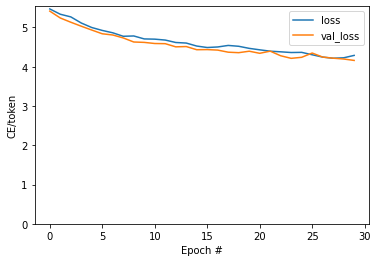

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

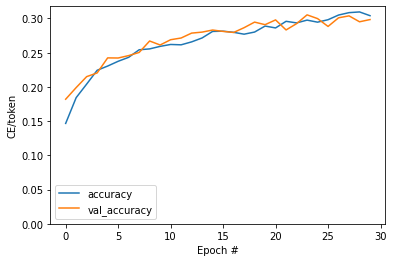

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Picking apart the model

Σε αυτό το σημείο έχουμε κάνει την εκπαίδευση του μοντέλου και με κάποιες βελτιστοποιήσεις που αναφέραμε, οπότε θα ελέξγουμε τώρα οπτικά πόσο επιτυχημένα είναι κάποια captions που παράγονται.

Αρχικά παρουσιάζουμε μια εικόνα με σχετικά αποτυχημένο caption.

Παρατηρούμε ότι το μοντέλο δεν κατάφερε να βρει το ότι ο άνθρωπος ιππεύει και δεν περπατά και θεώρησε την άμμο χιόνι.

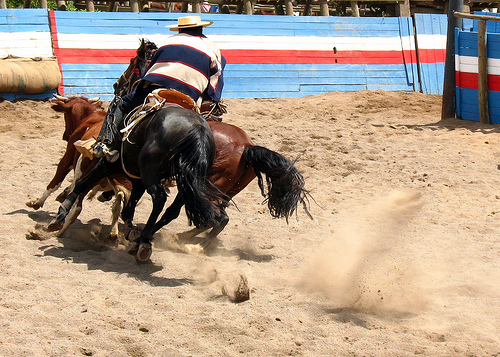

In [ ]:
Image.open('./image_dir/_83130699.jpg')

In [ ]:
image1 = load_image('./image_dir/_83130699.jpg')
result = model.simple_gen(image1, temperature=0.0) #we choose temperature as 0.0
print(result)

a man in a black shirt is walking on a man in the snow


In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 15, 64]), TensorShape([1, 2, 15, 64])]

In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=8, width=8,
    reduction='mean')

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.0000001, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       ], dtype=float32)>

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

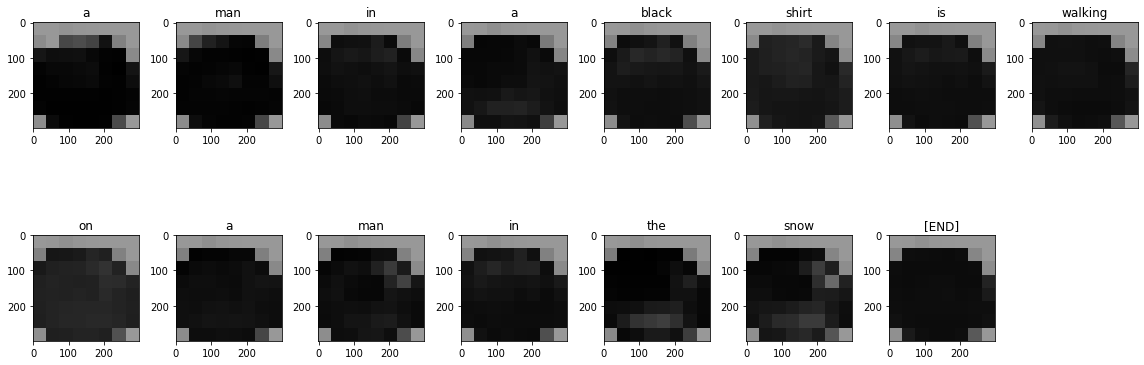

In [ ]:
plot_attention_maps(image1/255, str_tokens, attention_maps)

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=8, width=8,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

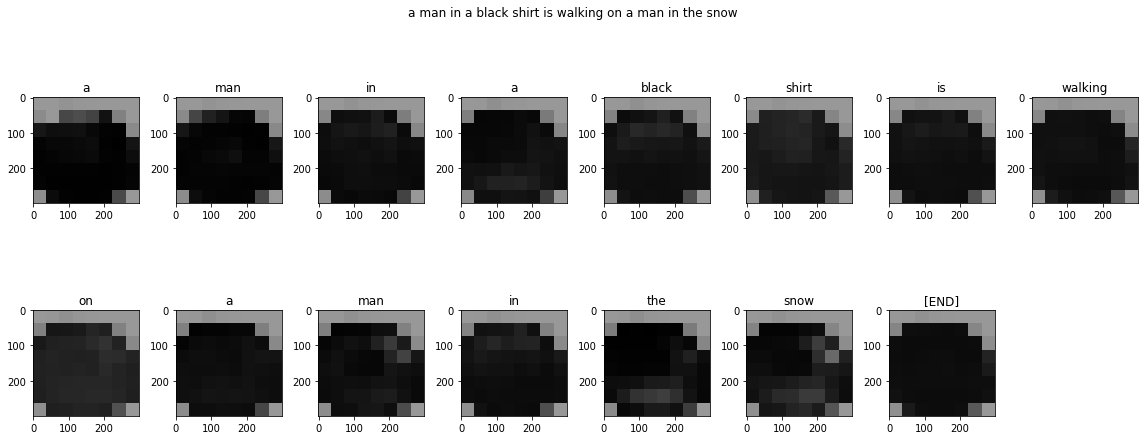

In [ ]:
run_and_show_attention(model, image1)

Τώρα θα βρούμε ένα καλύτερο παράδειγμα caption που παράγει το μοντέλο.

Σε αυτό το παράδειγμα το μοντέλο βρίσκει τα δύο άτομα που βρίσκονται μπροστά και κεντρικά αλλά δεν πετυχαίνει το φύλο τους. Ωστόσο πετυχαίνει τη στάση σώματος τους (sitting), παρά το λάθος "on a table".

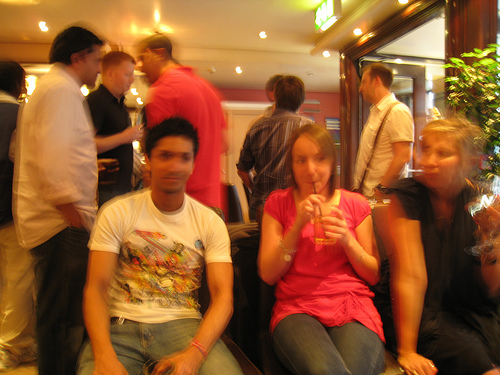

In [ ]:
Image.open('./image_dir/_127228870.jpg')

In [ ]:
image2 = load_image('./image_dir/_127228870.jpg')
result = model.simple_gen(image2, temperature=0.0) #we choose temperature as 0.0
print(result)

two men are sitting on a table


In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 8, 64]), TensorShape([1, 2, 8, 64])]

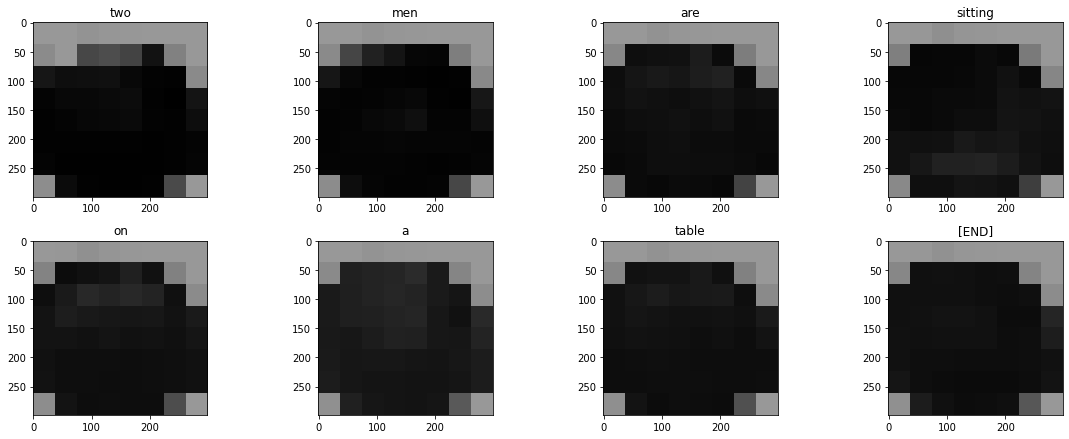

In [ ]:
plot_attention_maps(image2/255, str_tokens, attention_maps)

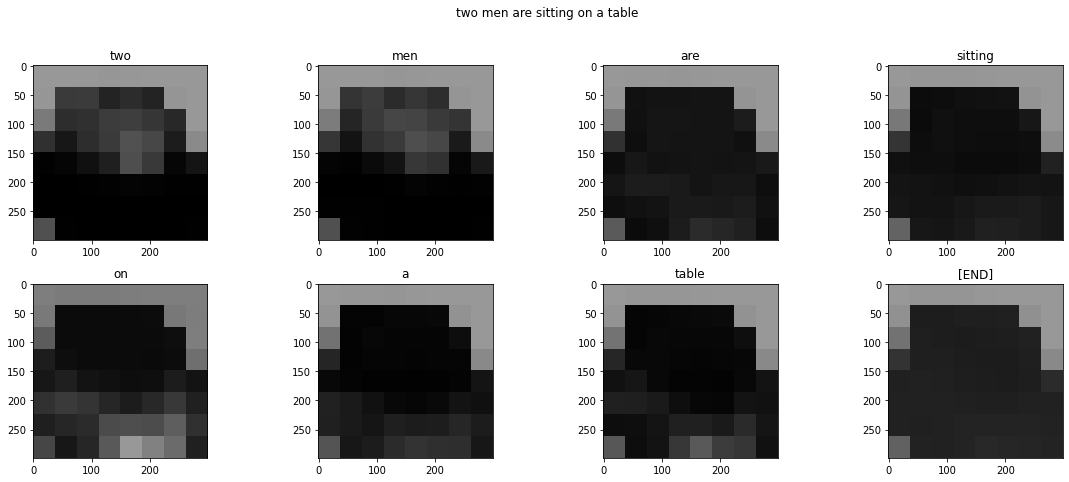

In [ ]:
run_and_show_attention(model, image2)

### Evaluation with bleu scores

Μετά την οπτική αξιολόγηση θα κρίνουμε το μοντέλο με βάση τα bleu scores.
Για να το κάνουμε αυτό θα χρησιμοποιήσουμε τα πρώτα 1000 δείγματα του test set (που είναι περίπου το 1/4) και θα δημιουργήσουμε ένα caption για το καθένα από αυτά.

Με την συνάρτηση *sentence_blue* θα βρούμε κάποια καλά και κακά bleu scores για μεμονωμένες εικόνες.

Με την συνάρτηση *corpus_bleu* θα βρούμε το bleu score και των 1000 εικόνων που χρησιμοποιούμε.

Ο λόγος που δεν χρησιμοποιούμε πάνω από 1000 captions είναι ότι η παραγωγή των captions είναι αρκετά χρονοβόρα (η παραγωγή 1000 captions ενδεικτικά πήρε 1 ώρα).

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.8 MB/s eta 0:00:00


Κάνουμε import τις βιβλιοθήκες για τα bleu scores και την Smoothing Function για να χρησιμοποιήσουμε την method1 όπως υποδείχθηκε στην εκφώνηση.

In [ ]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()

In [ ]:
references = []
result = []
images = []

for i in range (1000):
  image_ = load_image(test_captions[i][0])
  images.append(test_captions[i][0]) #array of all images directories
  result.append(model.simple_gen(image_, temperature=0.0)) #array of all predicted captions
  references.append(test_captions[i][1]) #array of all captions that are made by specials

<font color=indianred>**Cherry Picking**</font>

Παρακάτω παρουσιάζουμε μια εικόνα από τις 1000 που εμφανίζει καλό bleu score (96.57%)

Reference Caption: A woman in a blue shirt is walking across the street of an older looking district .
Prediction Caption: a man in a blue shirt is walking on a street


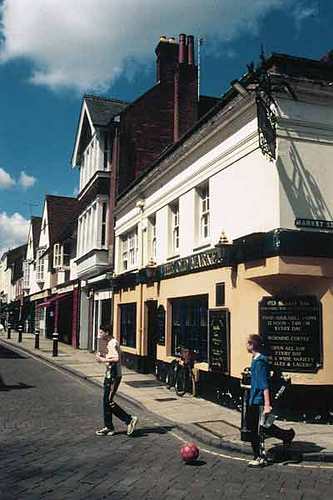

In [ ]:
print('Reference Caption:', references[646][0])
print('Prediction Caption:', result[646])
Image.open(images[646])

In [ ]:
nltk.translate.bleu_score.sentence_bleu(references[646], result[646], weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=chencherry.method1, auto_reweigh=False)

0.9657154470074827

<font color = lightgreen>**Nir Picking**</font>

Παρακάτω παρουσιάζουμε μια εικόνα από τις 1000 που εμφανίζει κακό bleu score (11.61%)

Reference Caption: two young girls htting each other with sacks on a field .
Prediction Caption: a woman in a blue shirt and a man in a blue shirt and a man in a man in a blue shirt and a blue shirt and a blue shirt and a man in a man in a blue shirt and a man in a black shirt and


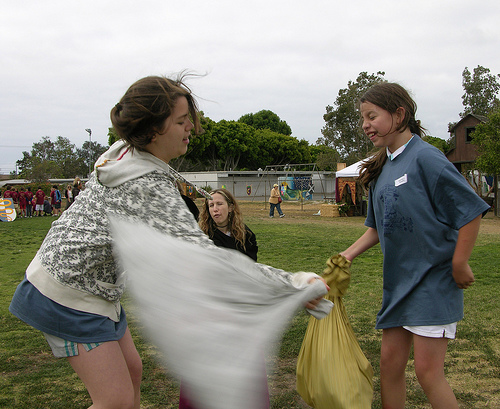

In [ ]:
print('Reference Caption:', references[344][0])
print('Prediction Caption:', result[344])
Image.open(images[344])

In [ ]:
nltk.translate.bleu_score.sentence_bleu(references[344], result[344], weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=chencherry.method1, auto_reweigh=False)

0.1161864374298485

**Total bleu score**

Το συνολικό bleu score που καταφέραμε να επιτύχουμε (44.73%)

In [ ]:
nltk.translate.bleu_score.corpus_bleu(references, result, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=chencherry.method1, auto_reweigh=False)

0.44731133521932087